Use neural network to generate PID parameters. Neural network is trained using a model of the plant so we don't need to know jacobian of plant. Model is trained on plant outputs offline.

V3.1 PID neural network takes in previous y value as parameter

V3.2 Take absolute value of Kp, Ki, Kd

V3.3 PID control the plant while training with a manually tuned PID controller

V3.4 Remove 3.3 changes. Initialize bias term with ones

V3.5 Added another layer to model neural network. Initialized only model nn with zeros. Increased NN model size to 16

V3.6 Changed to Adam Optimizer. Increased model to 3 layers: 16, 8 ,4. Added 10 epochs. Lowered learning rate

V3.7 Allowing model nn weight updates in online training

V3.8 Remove 3.7 changes. Added layer to PID nn: 8, 3. Switched to leaky relu in model nn

V3.9 Model hl: 4, 8, 8, 4. PID hl: 8, 5, 3

(V4.0 LSTM didn't show much difference in model learning)

V3.X.0 Split PID neural network into 3 separate networks

V3.X.1 input error into PID neural network. Switched PID to leaky relu. Modified offline training signal to combine sin and square

V3.X.2 Minimize loss E(y, r, y_m). Rolling offline and online training into online training

V3.X.3 Removed 3.X.2 changes. Changed gain update to delta. Fixed resetting y_0. Fixed PID update (e was not self.e)

V3.X.4 Removed delta gain update. Use learned PID in offline training. Reduced steps by half.

V3.X.5 Removed 3.X.0 changes

V3.X.6 Removed 3.X.5 changes. Removed limit on I term. Increased step x4, increased square interval to 500. Start square wave at 0

V3.X.7 Use difference between plant and model as PID nn input

V3.X.8 Removed 3.X.7 change, combine offline and online training into one. Reduced learning rate to 0.001 for model. Kept lr at 0.01 for PID

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import tensorflow as tf
from tensorflow.python.framework import ops

In [2]:
d_t = 0.01
d_t_decimal = str(d_t)[::-1].find('.')
steps = 6000

In [3]:
class PID:
    def __init__(self, Kp=0, Ki=0, Kd=0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
#         self.I_max = 20
        self.e = 0
        self.t = 0
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0
        
    def set_state(self, e, t):
        self.e = e
        self.t = t
        
    def update(self, Kp=None, Ki=None, Kd=None):
        if Kp is not None and Ki is not None and Kd is not None:
            self.Kp = Kp
            self.Ki = Ki
            self.Kd = Kd
        
        delta_time = self.t - self.t_prev
        delta_error = self.e - self.e_prev
        
        self.P = self.e
        
        self.I += self.e * delta_time

#         if (self.I < -self.I_max):
#             self.I = -self.I_max
#         elif (self.I > self.I_max):
#             self.I = self.I_max

        if delta_time > 0:
            self.D = delta_error / delta_time
        else:
            self.D = 0

        self.t_prev = self.t
        self.e_prev = self.e

        self.u = self.Kp * self.P + self.Ki * self.I + self.Kd * self.D
        return np.float32(self.u)
        
    def d_update(self, Kp, Ki, Kd):
        return np.float32(self.P), np.float32(self.I), np.float32(self.D)
    
    def reset(self):
        self.e = 0
        self.t = 0
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0


In [4]:
def plant_process(y, t, u):
    K = 0.01
    tau = 1.0
    T = 0.2
    
    t_delay = round(t-T, d_t_decimal)
    if (t_delay<= 0) or (t_delay<0.0):
        u_delay = u[0]
    else:
        step_t = int(t_delay/d_t)-1
        if step_t >= steps:
            u_delay = u[-1]
        else: 
            u_delay = u[step_t]  
        
    dydt = (-y + K*u_delay)/tau
    return dydt

def plant(y_0, t1, t2, u):
    ts = [t1, t2]
    return odeint(plant_process, y_0, ts, args=(u,))[1]

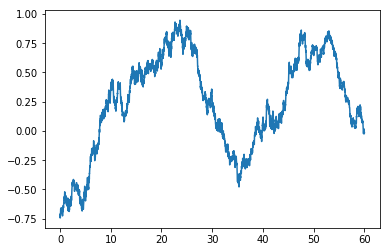

In [5]:
interval = 500
r_steps = steps//interval

r_sq = np.zeros(steps)
up = 0

for i in range(r_steps):
    if i < r_steps-1:
        r_sq[i * interval:(i+1)*interval] = up
    else:
        r_sq[i * interval:] = up
    if up > 0:
        up = -1
    else:
        up = 1

t = np.linspace(0, d_t*steps, steps)
r_sin = np.sin(t)

def gen_rand_sig(t):
    N = 1000
    x = np.random.normal(scale=10.0, size=len(t))
    return np.convolve(x, np.ones((N,))/N)[(N-1):] 
    
r_rand = gen_rand_sig(t)
plt.plot(t, r_rand)

r_combo = np.append(r_sin[:steps//2], r_sq[steps//2:])

### Plant control with neural network

In [8]:
pid = PID(1, 1, 1)

np_update = np.vectorize(pid.update)
np_d_update = np.vectorize(pid.d_update)

def tf_d_update(Kp, Ki, Kd,name=None):
    with tf.name_scope(name, "d_update", [Kp, Ki, Kd]) as name:
        y = tf.py_func(np_d_update,
                        [Kp, Ki, Kd],
                        (tf.float32, tf.float32, tf.float32),
                        name=name,
                        stateful=False)
        return y

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):

    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))

    tf.RegisterGradient(rnd_name)(grad)  # see _MySquareGrad for grad example
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def updategrad(op, grad):
    Kp, Ki, Kd = op.inputs
    
    dudKp, dudKi, dudKd = tf_d_update(Kp, Ki, Kd)
    return grad * dudKp, grad * dudKi, grad * dudKd


def tf_update(Kp, Ki, Kd, name=None):

    with tf.name_scope(name, "update", [Kp, Ki, Kd]) as name:
        y = py_func(np_update,
                        [Kp, Ki, Kd],
                        [tf.float32],
                        name=name,
                        grad=updategrad)  # <-- here's the call to the gradient
        return y[0]

hm1 = 4
hm2 = 8
hm3 = 8
hm4 = 4

hpKp1 = 8
hpKi1 = 8
hpKd1 = 8
hpKp2 = 3
hpKi2 = 3
hpKd2 = 3

graph = tf.Graph()
with graph.as_default():
    
    tf_r = tf.placeholder(tf.float32,shape=())
    tf_y_plant = tf.placeholder(tf.float32,shape=())
    tf_e = tf.placeholder(tf.float32,shape=())
    tf_u_save = tf.placeholder(tf.float32,shape=())
    tf_learning_rate = tf.placeholder(tf.float32, shape=())

              
    # Model NN    
    wm_1 = tf.Variable(tf.truncated_normal([1, hm1]))
    bm_1 = tf.Variable(tf.zeros([hm1]))   
    wm_2 = tf.Variable(tf.truncated_normal([hm1, hm2]))
    bm_2 = tf.Variable(tf.zeros([hm2]))
    wm_3 = tf.Variable(tf.truncated_normal([hm2, hm3]))
    bm_3 = tf.Variable(tf.zeros([hm3]))
    wm_4 = tf.Variable(tf.truncated_normal([hm3, hm4]))
    bm_4 = tf.Variable(tf.zeros([hm4]))
    wm_5 = tf.Variable(tf.truncated_normal([hm4, 1]))
    bm_5 = tf.Variable(tf.zeros([1]))
    
    # PID param NN
    wpid_Kp_1 = tf.Variable(tf.truncated_normal([1, hpKp1]))
    bpid_Kp_1 = tf.Variable(tf.ones([hpKp1]))   
    wpid_Kp_2 = tf.Variable(tf.truncated_normal([hpKp1, hpKp2]))
    bpid_Kp_2 = tf.Variable(tf.ones([hpKp2]))
    wpid_Kp_3 = tf.Variable(tf.truncated_normal([hpKp2, 1]))
    bpid_Kp_3 = tf.Variable(tf.ones([1]))
    
    wpid_Ki_1 = tf.Variable(tf.truncated_normal([1, hpKi1]))
    bpid_Ki_1 = tf.Variable(tf.ones([hpKi1]))   
    wpid_Ki_2 = tf.Variable(tf.truncated_normal([hpKi1, hpKi2]))
    bpid_Ki_2 = tf.Variable(tf.ones([hpKi2]))
    wpid_Ki_3 = tf.Variable(tf.truncated_normal([hpKi2, 1]))
    bpid_Ki_3 = tf.Variable(tf.ones([1]))
    
    wpid_Kd_1 = tf.Variable(tf.truncated_normal([1, hpKd1]))
    bpid_Kd_1 = tf.Variable(tf.ones([hpKd1]))   
    wpid_Kd_2 = tf.Variable(tf.truncated_normal([hpKd1, hpKd2]))
    bpid_Kd_2 = tf.Variable(tf.ones([hpKd2]))
    wpid_Kd_3 = tf.Variable(tf.truncated_normal([hpKd2, 1]))
    bpid_Kd_3 = tf.Variable(tf.ones([1]))

    def model_fp(input_value):
        z1 = tf.matmul(input_value, wm_1) + bm_1
        a1 = tf.nn.leaky_relu(z1)
        
        z2 = tf.matmul(a1, wm_2) + bm_2
        a2 = tf.nn.leaky_relu(z2)
        
        z3 = tf.matmul(a2, wm_3) + bm_3
        a3 = tf.nn.leaky_relu(z3)
        
        z4 = tf.matmul(a3, wm_4) + bm_4
        a4 = tf.nn.leaky_relu(z4)
        
        return tf.matmul(a4, wm_5) + bm_5
        
    
 
    def pid_fp(input_value, w1, b1, w2, b2, w3, b3):
        z1 = tf.matmul(input_value, w1) + b1
        a1 = tf.nn.leaky_relu(z1)
        z2 = tf.matmul(a1, w2) + b2
        a2 = tf.nn.leaky_relu(z2)
        return tf.matmul(a2, w3) + b3
    
    # Forward prop PID
    e_rs = tf.reshape(tf_e, (1, 1))
    
    Kp = pid_fp(e_rs, wpid_Kp_1, bpid_Kp_1, wpid_Kp_2, bpid_Kp_2, wpid_Kp_3, bpid_Kp_3)
    Ki = pid_fp(e_rs, wpid_Ki_1, bpid_Ki_1, wpid_Ki_2, bpid_Ki_2, wpid_Ki_3, bpid_Ki_3)
    Kd = pid_fp(e_rs, wpid_Kd_1, bpid_Kd_1, wpid_Kd_2, bpid_Kd_2, wpid_Kd_3, bpid_Kd_3)
    
    Kp_abs = tf.math.abs(Kp)
    Ki_abs = tf.math.abs(Ki)
    Kd_abs = tf.math.abs(Kd)
    
    u_nn = tf_update(Kp_abs, Ki_abs, Kd_abs)
#     u_nn = tf_update(Kp, Ki, Kd)

    
    # Forward prop model
    y_model = model_fp(u_nn)
    
    pid_var_list = [wpid_Kp_1, bpid_Kp_1, wpid_Kp_2, bpid_Kp_2, wpid_Kp_3, bpid_Kp_3,
                   wpid_Ki_1, bpid_Ki_1, wpid_Ki_2, bpid_Ki_2, wpid_Ki_3, bpid_Ki_3,
                   wpid_Kd_1, bpid_Kd_1, wpid_Kd_2, bpid_Kd_2, wpid_Kd_3, bpid_Kd_3]
    pid_loss = tf.losses.mean_squared_error(tf_r, tf.reshape(y_model, ()))
    pid_opt = tf.train.AdamOptimizer(tf_learning_rate).minimize(pid_loss, var_list=pid_var_list)
    
    
    # Forward prop model (we already have the u value from before)
    y_model_post_pid = model_fp(tf.reshape(tf_u_save, (1, 1)))

    model_var_list = [wm_1, bm_1, wm_2, bm_2, wm_3, bm_3, wm_4, bm_4, wm_5, bm_5]
    model_loss = tf.losses.mean_squared_error(tf_y_plant, tf.reshape(y_model_post_pid, ()))
    model_opt = tf.train.AdamOptimizer(tf_learning_rate).minimize(model_loss, var_list=model_var_list)


In [9]:
epochs = 10

y_0 = 0

y_p = np.zeros(steps)
y_m = np.zeros(steps)
u = np.zeros(steps)

Kp = np.zeros(steps)
Ki = np.zeros(steps)
Kd = np.zeros(steps)

l_pid = np.zeros(steps * epochs)
l_model = np.zeros(steps * epochs) 

lr_pid = 0.01
lr_model = 0.001

r = r_sq

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for j in range(epochs):
        print("Epoch:", j)
        #Reset values
        y_0 = 0
        y_p = np.zeros(steps)
        y_m = np.zeros(steps)
        u = np.zeros(steps)
        
        for i in range(steps)[1:]:  

            e = r[i] - y_0
            t_prev = t[i-1]
            t_cur = t[i]
            pid.set_state(e, t_cur)

            # Get get PID parameters and get control signal
            # Send to model to train PID param NN
            feed_dict = {tf_e:e, tf_r:r[i], tf_learning_rate:lr_pid}
            _, l_pid[i + j*steps], y_m[i], u[i] = session.run([pid_opt, pid_loss, y_model, u_nn], 
                                                    feed_dict=feed_dict)
            y_p[i] = plant(y_0, t_prev, t_cur, u)
            
            feed_dict = {tf_y_plant:y_p[i], tf_u_save: u[i], tf_learning_rate:lr_model}
            _, l_model[i + j*steps] = session.run([model_opt, model_loss], feed_dict=feed_dict)
            
            y_0 = y_p[i]
            
        print("PID Loss", sum(l_pid[j * steps:i + j*steps])/(i + j*steps))
        print("Model Loss", sum(l_model[j * steps:i + j*steps])/(i + j*steps))


    #Reset values
    y_0 = 0
    y_p = np.zeros(steps)
    y_m = np.zeros(steps)
    u = np.zeros(steps)
    
    for i in range(len(t))[1:]:  
        
        e = r[i] - y_0
        t_prev = t[i-1]
        t_cur = t[i]
        pid.set_state(e, t_cur)
        
        # Get get PID parameters and get control signal
        # Send to model to train PID param NN
        feed_dict = {tf_e:e, tf_r:r[i]}
        y_m[i], u[i] = session.run([y_model, u_nn], feed_dict=feed_dict)
        Kp[i] = pid.Kp
        Ki[i] = pid.Ki
        Kd[i] = pid.Kd
        
        y_p[i] = plant(y_0, t_prev, t_cur, u)
        y_0 = y_p[i]

Epoch: 0
PID Loss 0.9315051748007322
Model Loss 0.0982023371430143
Epoch: 1
PID Loss 0.41194117807662534
Model Loss 0.05567561961754121
Epoch: 2
PID Loss 0.410519145012229
Model Loss 0.16232871553662281
Epoch: 3
PID Loss 0.22842989904421995
Model Loss 0.05457340210191485
Epoch: 4
PID Loss 0.19987775683830056
Model Loss 0.1234118477274142
Epoch: 5
PID Loss 0.16365530391616415
Model Loss 0.04959302445262458
Epoch: 6
PID Loss 0.1055248748786073
Model Loss 0.017221388732746576
Epoch: 7
PID Loss 0.08502413038947458
Model Loss 0.022839300858268404
Epoch: 8
PID Loss 0.1098594427592814
Model Loss 0.029879161632307975
Epoch: 9
PID Loss 0.07157283345118065
Model Loss 0.011355566226380431


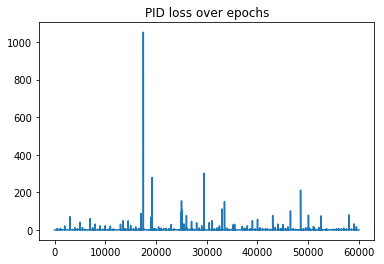

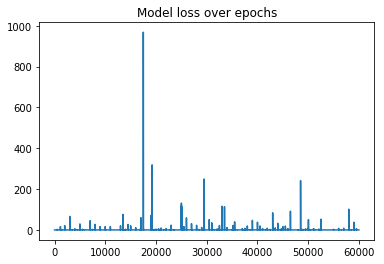

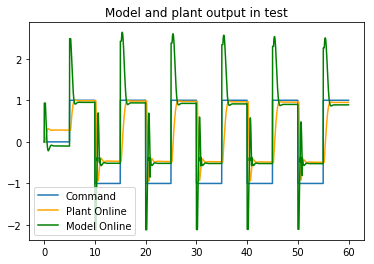

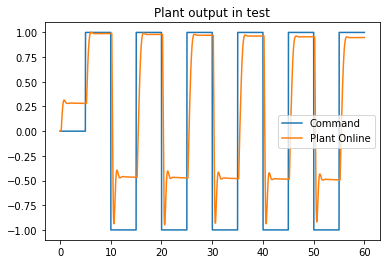

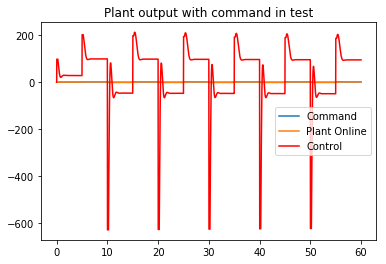

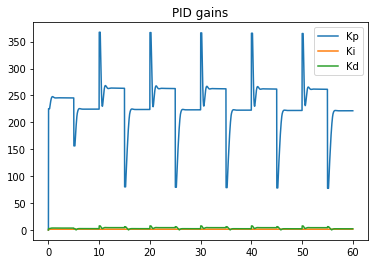

In [11]:
plt.plot(l_pid)
plt.title('PID loss over epochs')
plt.show()

plt.plot(l_model)
plt.title('Model loss over epochs')
plt.show()

plt.plot(t, r)
plt.plot(t, y_p, color='orange')
plt.plot(t, y_m, color='green')
plt.title('Model and plant output in test')
plt.legend(('Command', 'Plant Online', 'Model Online'))
plt.show()

plt.plot(t, r)
plt.plot(t, y_p)
plt.title('Plant output in test')
plt.legend(('Command', 'Plant Online'))
plt.show()

plt.plot(t, r)
plt.plot(t, y_p)
plt.plot(t, u, color='red')
plt.title('Plant output with command in test')
plt.legend(('Command', 'Plant Online', 'Control'))
plt.show()

plt.plot(t, Kp)
plt.plot(t, Ki)
plt.plot(t, Kd)
plt.title('PID gains')
plt.legend(('Kp', 'Ki', 'Kd'))
plt.show()